In [4]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import polars as pl
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
import warnings

warnings.filterwarnings('ignore')

dataPath = "/kaggle/input/home-credit-credit-risk-model-stability/"

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All"
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/home-credit-credit-risk-model-stability/sample_submission.csv
/kaggle/input/home-credit-credit-risk-model-stability/feature_definitions.csv
/kaggle/input/home-credit-credit-risk-model-stability/parquet_files/test/test_deposit_1.parquet
/kaggle/input/home-credit-credit-risk-model-stability/parquet_files/test/test_applprev_2.parquet
/kaggle/input/home-credit-credit-risk-model-stability/parquet_files/test/test_static_cb_0.parquet
/kaggle/input/home-credit-credit-risk-model-stability/parquet_files/test/test_static_0_0.parquet
/kaggle/input/home-credit-credit-risk-model-stability/parquet_files/test/test_credit_bureau_a_1_3.parquet
/kaggle/input/home-credit-credit-risk-model-stability/parquet_files/test/test_credit_bureau_a_1_2.parquet
/kaggle/input/home-credit-credit-risk-model-stability/parquet_files/test/test_tax_registry_b_1.parquet
/kaggle/input/home-credit-credit-risk-model-stability/parquet_files/test/test_static_0_2.parquet
/kaggle/input/home-credit-credit-risk-model-st

## **Goal of the Competition**

The goal of this competition is to predict which clients are more likely to default on their loans. The evaluation will favor solutions that are stable over time.

Your participation may offer consumer finance providers a more reliable and longer-lasting way to assess a potential client’s default risk.

## **Loading the Data**

We will now load the data and get it in the right format. We will conduct exploratory data analysis and create a baseline submission that we can iterate and improve on.

In [9]:
def set_table_dtypes(df: pl.DataFrame) -> pl.DataFrame:
    # implement here all desired dtypes for tables
    # the following is just an example
    for col in df.columns:
        # last letter of column name will help you determine the type
        if col[-1] in ("P", "A"):
            df = df.with_columns(pl.col(col).cast(pl.Float64).alias(col))

    return df

def convert_strings(df: pd.DataFrame) -> pd.DataFrame:
    for col in df.columns:
        if df[col].dtype.name in ['object', 'string']:
            df[col] = df[col].astype("string").astype('category')
            current_categories = df[col].cat.categories
            new_categories = current_categories.to_list() + ["Unknown"]
            new_dtype = pd.CategoricalDtype(categories=new_categories, ordered=True)
            df[col] = df[col].astype(new_dtype)
    return df

In [10]:
train_basetable = pl.read_csv(dataPath + "csv_files/train/train_base.csv")
train_static = pl.concat(
    [
        pl.read_csv(dataPath + "csv_files/train/train_static_0_0.csv").pipe(set_table_dtypes),
        pl.read_csv(dataPath + "csv_files/train/train_static_0_1.csv").pipe(set_table_dtypes),
    ],
    how="vertical_relaxed",
)
train_static_cb = pl.read_csv(dataPath + "csv_files/train/train_static_cb_0.csv").pipe(set_table_dtypes)
train_person_1 = pl.read_csv(dataPath + "csv_files/train/train_person_1.csv").pipe(set_table_dtypes)
train_credit_bureau_b_2 = pl.read_csv(dataPath + "csv_files/train/train_credit_bureau_b_2.csv").pipe(set_table_dtypes)

In [11]:
test_basetable = pl.read_csv(dataPath + "csv_files/test/test_base.csv")
test_static = pl.concat(
    [
        pl.read_csv(dataPath + "csv_files/test/test_static_0_0.csv").pipe(set_table_dtypes),
        pl.read_csv(dataPath + "csv_files/test/test_static_0_1.csv").pipe(set_table_dtypes),
        pl.read_csv(dataPath + "csv_files/test/test_static_0_2.csv").pipe(set_table_dtypes),
    ],
    how="vertical_relaxed",
)
test_static_cb = pl.read_csv(dataPath + "csv_files/test/test_static_cb_0.csv").pipe(set_table_dtypes)
test_person_1 = pl.read_csv(dataPath + "csv_files/test/test_person_1.csv").pipe(set_table_dtypes)
test_credit_bureau_b_2 = pl.read_csv(dataPath + "csv_files/test/test_credit_bureau_b_2.csv").pipe(set_table_dtypes)

## **Feature Engineering**

We will join the tables on case_id. (There are additional ways we can work with the data, but we will leave this as is for now.)

In [12]:
# We need to use aggregation functions in tables with depth > 1, so tables that contain num_group1 column or
# also num_group2 column.
train_person_1_feats_1 = train_person_1.group_by("case_id").agg(
    pl.col("mainoccupationinc_384A").max().alias("mainoccupationinc_384A_max"),
    (pl.col("incometype_1044T") == "SELFEMPLOYED").max().alias("mainoccupationinc_384A_any_selfemployed")
)

# Here num_group1=0 has special meaning, it is the person who applied for the loan.
train_person_1_feats_2 = train_person_1.select(["case_id", "num_group1", "housetype_905L"]).filter(
    pl.col("num_group1") == 0
).drop("num_group1").rename({"housetype_905L": "person_housetype"})

# Here we have num_goup1 and num_group2, so we need to aggregate again.
train_credit_bureau_b_2_feats = train_credit_bureau_b_2.group_by("case_id").agg(
    pl.col("pmts_pmtsoverdue_635A").max().alias("pmts_pmtsoverdue_635A_max"),
    (pl.col("pmts_dpdvalue_108P") > 31).max().alias("pmts_dpdvalue_108P_over31")
)

# We will process in this examples only A-type and M-type columns, so we need to select them.
selected_static_cols = []
for col in train_static.columns:
    if col[-1] in ("A", "M"):
        selected_static_cols.append(col)
print(selected_static_cols)

selected_static_cb_cols = []
for col in train_static_cb.columns:
    if col[-1] in ("A", "M"):
        selected_static_cb_cols.append(col)
print(selected_static_cb_cols)

# Join all tables together.
data = train_basetable.join(
    train_static.select(["case_id"]+selected_static_cols), how="left", on="case_id"
).join(
    train_static_cb.select(["case_id"]+selected_static_cb_cols), how="left", on="case_id"
).join(
    train_person_1_feats_1, how="left", on="case_id"
).join(
    train_person_1_feats_2, how="left", on="case_id"
).join(
    train_credit_bureau_b_2_feats, how="left", on="case_id"
)

['amtinstpaidbefduel24m_4187115A', 'annuity_780A', 'annuitynextmonth_57A', 'avginstallast24m_3658937A', 'avglnamtstart24m_4525187A', 'avgoutstandbalancel6m_4187114A', 'avgpmtlast12m_4525200A', 'credamount_770A', 'currdebt_22A', 'currdebtcredtyperange_828A', 'disbursedcredamount_1113A', 'downpmt_116A', 'inittransactionamount_650A', 'lastapprcommoditycat_1041M', 'lastapprcommoditytypec_5251766M', 'lastapprcredamount_781A', 'lastcancelreason_561M', 'lastotherinc_902A', 'lastotherlnsexpense_631A', 'lastrejectcommoditycat_161M', 'lastrejectcommodtypec_5251769M', 'lastrejectcredamount_222A', 'lastrejectreason_759M', 'lastrejectreasonclient_4145040M', 'maininc_215A', 'maxannuity_159A', 'maxannuity_4075009A', 'maxdebt4_972A', 'maxinstallast24m_3658928A', 'maxlnamtstart6m_4525199A', 'maxoutstandbalancel12m_4187113A', 'maxpmtlast3m_4525190A', 'previouscontdistrict_112M', 'price_1097A', 'sumoutstandtotal_3546847A', 'sumoutstandtotalest_4493215A', 'totaldebt_9A', 'totalsettled_863A', 'totinstallas

In [14]:
test_person_1_feats_1 = test_person_1.group_by("case_id").agg(
    pl.col("mainoccupationinc_384A").max().alias("mainoccupationinc_384A_max"),
    (pl.col("incometype_1044T") == "SELFEMPLOYED").max().alias("mainoccupationinc_384A_any_selfemployed")
)

test_person_1_feats_2 = test_person_1.select(["case_id", "num_group1", "housetype_905L"]).filter(
    pl.col("num_group1") == 0
).drop("num_group1").rename({"housetype_905L": "person_housetype"})

test_credit_bureau_b_2_feats = test_credit_bureau_b_2.group_by("case_id").agg(
    pl.col("pmts_pmtsoverdue_635A").max().alias("pmts_pmtsoverdue_635A_max"),
    (pl.col("pmts_dpdvalue_108P") > 31).max().alias("pmts_dpdvalue_108P_over31")
)

data_submission = test_basetable.join(
    test_static.select(["case_id"]+selected_static_cols), how="left", on="case_id"
).join(
    test_static_cb.select(["case_id"]+selected_static_cb_cols), how="left", on="case_id"
).join(
    test_person_1_feats_1, how="left", on="case_id"
).join(
    test_person_1_feats_2, how="left", on="case_id"
).join(
    test_credit_bureau_b_2_feats, how="left", on="case_id"
)

In [15]:
case_ids = data["case_id"].unique().shuffle(seed=1)
case_ids_train, case_ids_test = train_test_split(case_ids, train_size=0.6, random_state=1)
case_ids_valid, case_ids_test = train_test_split(case_ids_test, train_size=0.5, random_state=1)

cols_pred = []
for col in data.columns:
    if col[-1].isupper() and col[:-1].islower():
        cols_pred.append(col)

print(cols_pred)

def from_polars_to_pandas(case_ids: pl.DataFrame) -> pl.DataFrame:
    return (
        data.filter(pl.col("case_id").is_in(case_ids))[["case_id", "WEEK_NUM", "target"]].to_pandas(),
        data.filter(pl.col("case_id").is_in(case_ids))[cols_pred].to_pandas(),
        data.filter(pl.col("case_id").is_in(case_ids))["target"].to_pandas()
    )

base_train, X_train, y_train = from_polars_to_pandas(case_ids_train)
base_valid, X_valid, y_valid = from_polars_to_pandas(case_ids_valid)
base_test, X_test, y_test = from_polars_to_pandas(case_ids_test)

for df in [X_train, X_valid, X_test]:
    df = convert_strings(df)

['amtinstpaidbefduel24m_4187115A', 'annuity_780A', 'annuitynextmonth_57A', 'avginstallast24m_3658937A', 'avglnamtstart24m_4525187A', 'avgoutstandbalancel6m_4187114A', 'avgpmtlast12m_4525200A', 'credamount_770A', 'currdebt_22A', 'currdebtcredtyperange_828A', 'disbursedcredamount_1113A', 'downpmt_116A', 'inittransactionamount_650A', 'lastapprcommoditycat_1041M', 'lastapprcommoditytypec_5251766M', 'lastapprcredamount_781A', 'lastcancelreason_561M', 'lastotherinc_902A', 'lastotherlnsexpense_631A', 'lastrejectcommoditycat_161M', 'lastrejectcommodtypec_5251769M', 'lastrejectcredamount_222A', 'lastrejectreason_759M', 'lastrejectreasonclient_4145040M', 'maininc_215A', 'maxannuity_159A', 'maxannuity_4075009A', 'maxdebt4_972A', 'maxinstallast24m_3658928A', 'maxlnamtstart6m_4525199A', 'maxoutstandbalancel12m_4187113A', 'maxpmtlast3m_4525190A', 'previouscontdistrict_112M', 'price_1097A', 'sumoutstandtotal_3546847A', 'sumoutstandtotalest_4493215A', 'totaldebt_9A', 'totalsettled_863A', 'totinstallas

In [16]:
X_submission = data_submission[cols_pred].to_pandas()
X_submission = convert_strings(X_submission)

In [9]:
!pip install imbalanced-learn


In [17]:
print(f"Train: {X_train.shape}")
print(f"Valid: {X_valid.shape}")
print(f"Test: {X_test.shape}")

Train: (915995, 48)
Valid: (305332, 48)
Test: (305332, 48)


In [18]:
def fill_na(df, fill_value_numeric=0, fill_value_categorical='Missing', fill_value_default='Unknown'):
    """
    Fills missing values in a DataFrame.

    Parameters:
    df (pd.DataFrame): The DataFrame to fill missing values in.
    fill_value_numeric (int or float): The value to fill missing values with in numeric columns.
    fill_value_categorical (str): The value to fill missing values with in categorical columns.
    fill_value_default (str): The value to fill missing values with in other types of columns.

    Returns:
    pd.DataFrame: DataFrame with missing values filled.
    """
    for col in df.columns:
        if df[col].dtype.name == 'category':
            # Check if the category is already present before adding it
            if fill_value_categorical not in df[col].cat.categories:
                df[col] = df[col].cat.add_categories([fill_value_categorical])
            df[col] = df[col].fillna(fill_value_categorical)
        elif pd.api.types.is_numeric_dtype(df[col]):
            # Fill numeric columns with the specified numeric value
            df[col] = df[col].fillna(fill_value_numeric)
        else:
            # Fill other types of columns with the specified default value
            df[col] = df[col].fillna(fill_value_default)
    return df

# Apply fill_na to your datasets
X_train = fill_na(X_train)
X_valid = fill_na(X_valid)
X_test = fill_na(X_test)
X_submission = fill_na(X_submission)

In [19]:
cat_cols = [col for col in X_train.columns if X_train[col].dtype == 'category']
num_cols = [col for col in X_train.columns if col not in cat_cols]

In [20]:
from sklearn.preprocessing import LabelEncoder

label_encoders = {}
for col in cat_cols:
    le = LabelEncoder()
    all_values = pd.concat([X_train[col], X_valid[col],X_test[col],X_submission[col]], axis=0).astype(str)
    le.fit(all_values)
    X_train[col] = le.transform(X_train[col].astype(str))
    X_valid[col] = le.transform(X_valid[col].astype(str))
    X_test[col] = le.transform(X_test[col].astype(str))
    X_submission[col] = le.transform(X_submission[col].astype(str))
    label_encoders[col] = le

X_test_combined = np.hstack([X_test[cat_cols].values, X_test[num_cols].values])
X_train_combined = np.hstack([X_train[cat_cols].values, X_train[num_cols].values])
X_valid_combined = np.hstack([X_valid[cat_cols].values, X_valid[num_cols].values])
X_submission_combined = np.hstack([X_submission[cat_cols].values, X_submission[num_cols].values])

X_test = X_test_combined.astype('float32')
X_train = X_train_combined.astype('float32')
X_valid = X_valid_combined.astype('float32')
X_submission = X_submission_combined.astype('float32')

In [15]:
# from imblearn.over_sampling import SMOTE
# import pandas as pd
# import numpy as np

# # Applying SMOTE
# smote = SMOTE(random_state=42)
# X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

# # Print types of the data sets
# print("Type of X_train_smote:", type(X_train_smote))
# print("Type of y_train_smote:", type(y_train_smote))

In [21]:
print(type(X_train))
print(type(y_train))
print(type(X_valid))
print(type(y_valid))

<class 'numpy.ndarray'>
<class 'pandas.core.series.Series'>
<class 'numpy.ndarray'>
<class 'pandas.core.series.Series'>


In [22]:
import torch
import numpy as np

# Convert NumPy arrays to PyTorch tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
X_valid_tensor = torch.tensor(X_valid, dtype=torch.float32)

# Convert Pandas Series to NumPy arrays first, then to PyTorch tensors
y_train_array = y_train.to_numpy()  # Convert Pandas Series to NumPy array
y_valid_array = y_valid.to_numpy()  # Convert Pandas Series to NumPy array

# Convert to PyTorch tensors
y_train_tensor = torch.tensor(y_train_array, dtype=torch.float32)
y_valid_tensor = torch.tensor(y_valid_array, dtype=torch.float32)

# Verify the conversion
print(type(X_train_tensor))  # Should print <class 'torch.Tensor'>
print(type(y_train_tensor))  # Should print <class 'torch.Tensor'>
print(type(X_valid_tensor))  # Should print <class 'torch.Tensor'>
print(type(y_valid_tensor))  # Should print <class 'torch.Tensor'>

<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>


## **Deep Learning**

Deep learning is a type of machine learning that is used to teach artificial neural networks how to learn from vast amounts of data. These neural networks are designed to mimic the structure of the human brain, and they are composed of layers of interconnected nodes called neurons that work in concert to process and analyze information.

In the process of deep learning, the neural network is fed large amounts of data and then adjusts its parameters through a process called backpropagation to minimize the difference between its predicted output and the actual output. This allows the neural network to recognize patterns and make accurate predictions.

Deep learning has many practical applications, such as image and speech recognition, natural language processing, and self-driving cars. It has revolutionized the field of artificial intelligence and has contributed to significant advancements in research and development.

In [23]:
unique, counts = np.unique(y_train, return_counts=True)
print(np.asarray((unique, counts)).T)

[[     0 887123]
 [     1  28872]]


In [24]:
import numpy as np

# Simulating an imbalanced dataset with 90% of class 0 and 10% of class 1
y_train_np = np.random.choice([0, 1], size=(915995,), p=[0.9, 0.1])

In [25]:
unique, counts = np.unique(y_train_np, return_counts=True)
print("Class distribution before SMOTE:", np.asarray((unique, counts)).T)

Class distribution before SMOTE: [[     0 824343]
 [     1  91652]]


In [26]:
# Debugging prints
print("Shape of X_train before SMOTE:", X_train.shape)
print("Shape of y_train before SMOTE:", y_train_np.shape)

Shape of X_train before SMOTE: (915995, 48)
Shape of y_train before SMOTE: (915995,)


In [27]:
import pandas as pd
import numpy as np
from imblearn.over_sampling import SMOTE

# Convert X_train to a 2D NumPy array if it's a DataFrame
if isinstance(X_train, pd.DataFrame):
    X_train_array = X_train.values
else:
    # If it's a tensor, convert it to a NumPy array
    X_train_array = X_train.cpu().numpy() if hasattr(X_train, 'cpu') else np.array(X_train)

# Convert y_train to a NumPy array
y_train_array = np.array(y_train)

# Verify the shape of the arrays
print("Shape of X_train before SMOTE:", X_train_array.shape)
print("Shape of y_train before SMOTE:", y_train_array.shape)

# Ensure X_train is a 2D array and y_train is a 1D array
assert X_train_array.ndim == 2, f"Expected a 2D array for features, got {X_train_array.ndim}D"
assert y_train_array.ndim == 1, f"Expected a 1D array for labels, got {y_train_array.ndim}D"

# Apply SMOTE to balance the classes
smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train_array, y_train_array)

# Print information about the resampled data
print("New shape of X_train after SMOTE:", X_train_smote.shape)
print("New shape of y_train after SMOTE:", y_train_smote.shape)

# Check class distribution after SMOTE
unique, counts = np.unique(y_train_smote, return_counts=True)
print("Class distribution after SMOTE:", np.asarray((unique, counts)).T)

Shape of X_train before SMOTE: (915995, 48)
Shape of y_train before SMOTE: (915995,)
New shape of X_train after SMOTE: (1774246, 48)
New shape of y_train after SMOTE: (1774246,)
Class distribution after SMOTE: [[     0 887123]
 [     1 887123]]


In [28]:
# Define the desired sequence length and number of features
seq_length = 1  # As per your initial assumption
features = 48  # Match the flattened array's feature count

# Calculate the number of expected samples
expected_samples = X_train_smote.shape[0]

# Reshape to 3D using the expected number of samples, sequence length, and features
X_train_smote_3d = X_train_smote.reshape(expected_samples, seq_length, features)

# Verify the new shape
print("New shape of X_train_smote after reshaping to 3D:", X_train_smote_3d.shape)

# Check class distribution after SMOTE
unique_smote, counts_smote = np.unique(y_train_smote, return_counts=True)
print("Class distribution after SMOTE:", np.asarray((unique_smote, counts_smote)).T)

New shape of X_train_smote after reshaping to 3D: (1774246, 1, 48)
Class distribution after SMOTE: [[     0 887123]
 [     1 887123]]


In [29]:
import torch

# Convert to a PyTorch tensor
X_train_tensor = torch.tensor(X_train_smote_3d.astype('float32'))
y_train_tensor = torch.tensor(y_train_smote.astype('float32'))

In [25]:
# from torch.utils.data import DataLoader, TensorDataset

# # Create a dataset and dataloader
# train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
# train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)

In [30]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.tensorboard import SummaryWriter

class LSTMNetwork(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, bidirectional):
        super(LSTMNetwork, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.bidirectional = bidirectional

        # LSTM layer
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True, bidirectional=bidirectional)

        # Fully connected layer
        self.fc = nn.Linear(hidden_size * 2 if bidirectional else hidden_size, 1)

        # Activation function
        self.activation = nn.Sigmoid()

    def init_hidden(self, batch_size, device):
        # Initialize the number of directions based on bidirectional flag
        num_directions = 2 if self.bidirectional else 1
        h0 = torch.zeros(self.num_layers * num_directions, batch_size, self.hidden_size).to(device)
        c0 = torch.zeros(self.num_layers * num_directions, batch_size, self.hidden_size).to(device)
        return h0, c0

    def forward(self, x):
        batch_size = x.size(0)  # Extract the batch size from input tensor
        h0, c0 = self.init_hidden(batch_size, x.device)  # Initialize hidden states
        out, _ = self.lstm(x, (h0, c0))  # Pass the input and hidden states to the LSTM layer
        out = self.fc(out[:, -1, :])  # Take only the final output of the sequence
        return self.activation(out)

# Define the model parameters
input_size = 48
hidden_size = 128
num_layers = 2
bidirectional = True  # Depending on your model architecture

# Create the model and move to GPU if available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = LSTMNetwork(input_size, hidden_size, num_layers, bidirectional).to(device)

# Example data
batch_size = 32
seq_length = 1  # Replace with your desired sequence length
X_train_tensor = torch.randn(batch_size, seq_length, input_size).to(device)

# Forward pass to verify everything is correct
outputs = model(X_train_tensor)
print(f"Output shape: {outputs.shape}")  # Check the output shape

# Define the optimizer with added weight decay
optimizer = optim.Adam(model.parameters(), lr=0.0001, weight_decay=1e-4)

# Optionally add a learning rate scheduler
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)

# Define the loss function
criterion = nn.BCELoss()  # Binary Cross-Entropy Loss

# Set up TensorBoard
tensorboard_writer = SummaryWriter(log_dir='logs')

# Printing the model's architecture
print(model)

2024-05-08 22:00:58.091228: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-05-08 22:00:58.091338: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-05-08 22:00:58.238242: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


Output shape: torch.Size([32, 1])
LSTMNetwork(
  (lstm): LSTM(48, 128, num_layers=2, batch_first=True, bidirectional=True)
  (fc): Linear(in_features=256, out_features=1, bias=True)
  (activation): Sigmoid()
)


LSTM Neural Network

In [31]:
print("Shape of X_train:", X_train.shape)
print("Shape of y_train:", y_train.shape)

Shape of X_train: (915995, 48)
Shape of y_train: (915995,)


In [32]:
print(f"Shape of X_train_smote: {X_train_smote.shape}")
print(f"Shape of y_train_smote: {y_train_smote.shape}")
print(f"Shape of X_valid_tensor: {X_valid_tensor.shape}")
print(f"Shape of y_valid_tensor: {y_valid_tensor.shape}")

Shape of X_train_smote: (1774246, 48)
Shape of y_train_smote: (1774246,)
Shape of X_valid_tensor: torch.Size([305332, 48])
Shape of y_valid_tensor: torch.Size([305332])


In [33]:
from torch.utils.data import TensorDataset, DataLoader

# Reshape the training data to 3D
expected_samples_train = X_train_smote.shape[0]
seq_length = 1  # As each sample is a single sequence of length 1
features = X_train_smote.shape[1]

# Convert NumPy array to PyTorch tensor and reshape
X_train_smote_tensor = torch.tensor(X_train_smote, dtype=torch.float32).view(expected_samples_train, seq_length, features)
y_train_smote_tensor = torch.tensor(y_train_smote, dtype=torch.float32)

# Reshape the validation data to 3D
expected_samples_valid = X_valid_tensor.shape[0]
X_valid_tensor_3d = X_valid_tensor.view(expected_samples_valid, seq_length, features)
y_valid_tensor_3d = y_valid_tensor.view(expected_samples_valid)

# Create TensorDataset objects
train_dataset = TensorDataset(X_train_smote_tensor, y_train_smote_tensor)
valid_dataset = TensorDataset(X_valid_tensor_3d, y_valid_tensor_3d)

# Create DataLoader objects
train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=128, shuffle=False)

# Verify shapes for training and validation
print(f"Shape of X_train_smote_tensor: {X_train_smote_tensor.shape}")
print(f"Shape of X_valid_tensor_3d: {X_valid_tensor_3d.shape}")

Shape of X_train_smote_tensor: torch.Size([1774246, 1, 48])
Shape of X_valid_tensor_3d: torch.Size([305332, 1, 48])


In [61]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import torchmetrics
from torch.utils.tensorboard import SummaryWriter
import numpy as np
import pandas as pd

# Determine if a GPU is available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# Initialize global variables
seq_length = 1  # Assuming each sample is treated as a sequence of length 1
batch_size = 128
epochs = 20
early_stopping_patience = 5
early_stopping_counter = 0
best_valid_auroc = float('-inf')

# Convert input data to PyTorch tensors and reshape to 3D if necessary
def to_tensor_3d(X, seq_length, features):
    num_samples = X.shape[0]
    return torch.tensor(X, dtype=torch.float32).view(num_samples, seq_length, features)

# Check and convert the input data
expected_samples_train = X_train_smote.shape[0]
expected_samples_valid = X_valid_tensor.shape[0]
features = X_train_smote.shape[1]

# Reshape to 3D
X_train_smote_3d = to_tensor_3d(X_train_smote, seq_length, features)
X_valid_tensor_3d = to_tensor_3d(X_valid_tensor, seq_length, features)

# Convert labels to tensors
y_train_smote_tensor = torch.tensor(y_train_smote, dtype=torch.float32)
y_valid_tensor_3d = torch.tensor(y_valid_tensor, dtype=torch.float32)

# Initialize AUROC metrics for binary classification
train_auroc_metric = torchmetrics.AUROC(task='binary').to(device)
valid_auroc_metric = torchmetrics.AUROC(task='binary').to(device)

# Initialize the model with bidirectional=True and move it to the GPU (if available)
model = LSTMNetwork(input_size=features, hidden_size=128, num_layers=2, bidirectional=True).to(device)

# Optimizer and scheduler
optimizer = optim.Adam(model.parameters(), lr=0.0001, weight_decay=1e-4)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'max', patience=3, factor=0.5)

# Loss function
criterion = nn.BCELoss()

# TensorBoard
tensorboard_writer = SummaryWriter(log_dir='logs')

# Training and validation functions with modifications for early stopping and checkpointing
def train(model, criterion, optimizer, loader, auroc_metric):
    model.train()
    total_loss = 0
    auroc_metric.reset()
    for inputs, targets in loader:
        inputs, targets = inputs.to(device), targets.to(device)  # Move batch to GPU
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs.squeeze(), targets)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
        auroc_metric.update(outputs.sigmoid(), targets.int())  # Update the AUROC metric with new batch
    train_auroc = auroc_metric.compute()  # Compute the aggregated AUROC
    return total_loss / len(loader), train_auroc

def validate(model, criterion, loader, auroc_metric):
    model.eval()
    total_loss = 0
    auroc_metric.reset()
    with torch.no_grad():
        for inputs, targets in loader:
            inputs, targets = inputs.to(device), targets.to(device)  # Move batch to GPU
            outputs = model(inputs)
            loss = criterion(outputs.squeeze(), targets)
            total_loss += loss.item()
            auroc_metric.update(outputs.sigmoid(), targets.int())  # Update the AUROC metric with new batch
    val_auroc = auroc_metric.compute()  # Compute the aggregated AUROC
    return total_loss / len(loader), val_auroc

# # Training and validation loop
# for epoch in range(epochs):
#     # Create TensorDataset objects
#     train_dataset = TensorDataset(X_train_smote_3d, y_train_smote_tensor)
#     valid_dataset = TensorDataset(X_valid_tensor_3d, y_valid_tensor_3d)

#     # Create DataLoader objects
#     train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
#     valid_loader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False)

#     # Train and validate
#     train_loss, train_auroc = train(model, criterion, optimizer, train_loader, train_auroc_metric)
#     valid_loss, valid_auroc = validate(model, criterion, valid_loader, valid_auroc_metric)

#     # Update scheduler
#     scheduler.step(valid_auroc)

#     # Save best model
#     if valid_auroc > best_valid_auroc:
#         best_valid_auroc = valid_auroc
#         torch.save(model.state_dict(), 'best_model.pth')
#         early_stopping_counter = 0
#     else:
#         early_stopping_counter += 1
#         if early_stopping_counter >= early_stopping_patience:
#             print("Early stopping triggered!")
#             break

#     # Logging and printing
#     tensorboard_writer.add_scalar('Loss/train', train_loss, epoch)
#     tensorboard_writer.add_scalar('Loss/valid', valid_loss, epoch)
#     tensorboard_writer.add_scalar('AUROC/train', train_auroc, epoch)
#     tensorboard_writer.add_scalar('AUROC/valid', valid_auroc, epoch)

#     # Print statement
#     print(f'Epoch {epoch + 1}/{epochs}, Train Loss: {train_loss:.4f}, Valid Loss: {valid_loss:.4f}, Train AUROC: {train_auroc:.4f}, Valid AUROC: {valid_auroc:.4f}')

Using device: cuda


In [47]:
# Initialize lists to store metrics across epochs
train_losses = []
valid_losses = []
train_aurocs = []
valid_aurocs = []

# Training and validation loop
for epoch in range(epochs):
    # Create TensorDataset objects
    train_dataset = TensorDataset(X_train_smote_3d, y_train_smote_tensor)
    valid_dataset = TensorDataset(X_valid_tensor_3d, y_valid_tensor_3d)

    # Create DataLoader objects
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    valid_loader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False)

    # Train and validate
    train_loss, train_auroc = train(model, criterion, optimizer, train_loader, train_auroc_metric)
    valid_loss, valid_auroc = validate(model, criterion, valid_loader, valid_auroc_metric)

    # Update scheduler
    scheduler.step(valid_auroc)

    # Save best model
    if valid_auroc > best_valid_auroc:
        best_valid_auroc = valid_auroc
        torch.save(model.state_dict(), 'best_model.pth')
        early_stopping_counter = 0
    else:
        early_stopping_counter += 1
        if early_stopping_counter >= early_stopping_patience:
            print("Early stopping triggered!")
            break

    # Append metrics to lists for later visualization
    train_losses.append(train_loss)
    valid_losses.append(valid_loss)
    train_aurocs.append(train_auroc.item())  # Ensure it's a scalar value
    valid_aurocs.append(valid_auroc.item())

    # Logging and printing
    tensorboard_writer.add_scalar('Loss/train', train_loss, epoch)
    tensorboard_writer.add_scalar('Loss/valid', valid_loss, epoch)
    tensorboard_writer.add_scalar('AUROC/train', train_auroc, epoch)
    tensorboard_writer.add_scalar('AUROC/valid', valid_auroc, epoch)

    # Print statement
    print(f'Epoch {epoch + 1}/{epochs}, Train Loss: {train_loss:.4f}, Valid Loss: {valid_loss:.4f}, Train AUROC: {train_auroc:.4f}, Valid AUROC: {valid_auroc:.4f}')

# After the training loop ends, the lists contain all the epoch-wise metrics.
# Use these lists to visualize the training process or analyze trends.

Epoch 1/20, Train Loss: 0.6008, Valid Loss: 0.6340, Train AUROC: 0.7342, Valid AUROC: 0.6973
Epoch 2/20, Train Loss: 0.5986, Valid Loss: 0.6305, Train AUROC: 0.7368, Valid AUROC: 0.6979
Epoch 3/20, Train Loss: 0.5980, Valid Loss: 0.6103, Train AUROC: 0.7373, Valid AUROC: 0.6970
Epoch 4/20, Train Loss: 0.5979, Valid Loss: 0.6196, Train AUROC: 0.7376, Valid AUROC: 0.6973
Epoch 5/20, Train Loss: 0.5964, Valid Loss: 0.5984, Train AUROC: 0.7394, Valid AUROC: 0.6978
Epoch 6/20, Train Loss: 0.5941, Valid Loss: 0.6216, Train AUROC: 0.7416, Valid AUROC: 0.6976
Epoch 7/20, Train Loss: 0.5909, Valid Loss: 0.5861, Train AUROC: 0.7457, Valid AUROC: 0.6997
Epoch 8/20, Train Loss: 0.5890, Valid Loss: 0.5975, Train AUROC: 0.7478, Valid AUROC: 0.7003
Epoch 9/20, Train Loss: 0.5878, Valid Loss: 0.5948, Train AUROC: 0.7492, Valid AUROC: 0.7015
Epoch 10/20, Train Loss: 0.5866, Valid Loss: 0.5807, Train AUROC: 0.7505, Valid AUROC: 0.7014
Epoch 13/20, Train Loss: 0.5838, Valid Loss: 0.5994, Train AUROC: 0.7

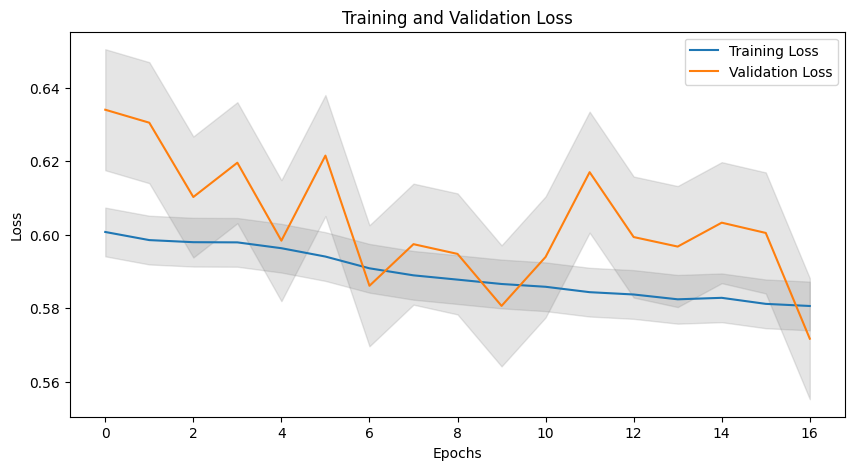

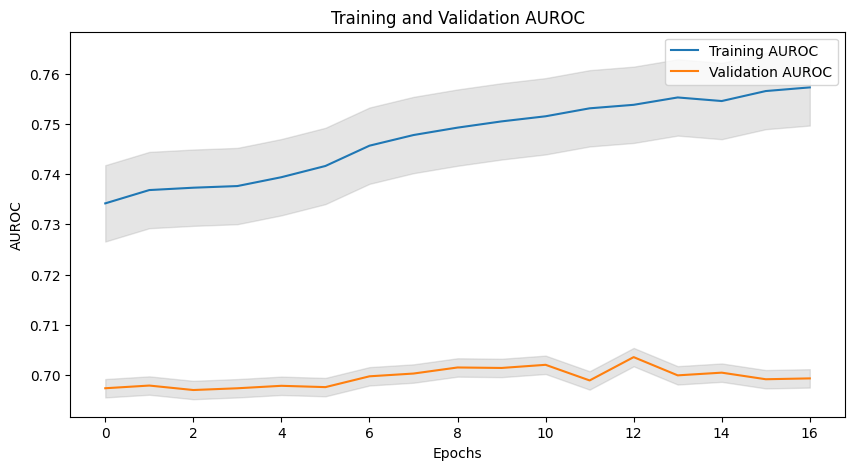

In [48]:
import matplotlib.pyplot as plt
import numpy as np

# Plot training and validation loss with standard deviation shading
plt.figure(figsize=(10, 5))

# Training loss and its standard deviation
train_loss_std = np.std(train_losses)
valid_loss_std = np.std(valid_losses)

plt.plot(train_losses, label='Training Loss')
plt.fill_between(range(len(train_losses)),
                 np.array(train_losses) - train_loss_std,
                 np.array(train_losses) + train_loss_std,
                 color='gray', alpha=0.2)

# Validation loss and its standard deviation
plt.plot(valid_losses, label='Validation Loss')
plt.fill_between(range(len(valid_losses)),
                 np.array(valid_losses) - valid_loss_std,
                 np.array(valid_losses) + valid_loss_std,
                 color='gray', alpha=0.2)

plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plot training and validation AUC with standard deviation shading
plt.figure(figsize=(10, 5))

# AUC standard deviation
train_auroc_std = np.std(train_aurocs)
valid_auroc_std = np.std(valid_aurocs)

plt.plot(train_aurocs, label='Training AUROC')
plt.fill_between(range(len(train_aurocs)),
                 np.array(train_aurocs) - train_auroc_std,
                 np.array(train_aurocs) + train_auroc_std,
                 color='gray', alpha=0.2)

plt.plot(valid_aurocs, label='Validation AUROC')
plt.fill_between(range(len(valid_aurocs)),
                 np.array(valid_aurocs) - valid_auroc_std,
                 np.array(valid_aurocs) + valid_auroc_std,
                 color='gray', alpha=0.2)

plt.title('Training and Validation AUROC')
plt.xlabel('Epochs')
plt.ylabel('AUROC')
plt.legend()
plt.show()

After running the code, TensorBoard logs can be visualized using the following command. This will open a web interface where you can view the loss and other metrics.

In [ ]:
# %load_ext tensorboard
# %tensorboard --logdir logs

We will now evaluate the neural network performance with AUC and gini stability below.

In [49]:
import torch
from torch.utils.data import TensorDataset, DataLoader
from sklearn.metrics import roc_auc_score

# Function to create 3D tensors from 2D input data
def to_tensor_3d(X, seq_length, features):
    num_samples = X.shape[0]
    return torch.tensor(X, dtype=torch.float32).view(num_samples, seq_length, features)

# Set batch size for prediction
batch_size = 128

# Process each dataset (train, validation, test) using batching
for base, X in [(base_train, X_train), (base_valid, X_valid), (base_test, X_test)]:
    seq_length = 1  # Assuming a single time step sequence length
    features = X.shape[1]  # Number of features per sample

    # Convert to 3D tensor
    X_tensor_3d = to_tensor_3d(X, seq_length, features)

    # Create a TensorDataset and DataLoader for batch processing
    dataset = TensorDataset(X_tensor_3d)
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=False)

    # Initialize an empty list to store predictions
    all_predictions = []

    # Set model to evaluation mode and predict in batches
    model.eval()
    with torch.no_grad():  # Disable gradients for prediction
        for batch in dataloader:
            X_batch = batch[0].to(device)
            y_pred = model(X_batch).squeeze().cpu().numpy()
            all_predictions.extend(y_pred)

    # Store predictions in the DataFrame
    base["score"] = all_predictions

# Print AUC scores using scikit-learn's roc_auc_score function
print(f'The AUC score on the train set is: {roc_auc_score(base_train["target"], base_train["score"])}')
print(f'The AUC score on the valid set is: {roc_auc_score(base_valid["target"], base_valid["score"])}')
print(f'The AUC score on the test set is: {roc_auc_score(base_test["target"], base_test["score"])}')

The AUC score on the train set is: 0.719540652527537
The AUC score on the valid set is: 0.700192365693128
The AUC score on the test set is: 0.7006242476706197


In [50]:
import numpy as np
from sklearn.metrics import roc_auc_score

def gini_stability(base, w_fallingrate=88.0, w_resstd=-0.5):
    # Calculate Gini coefficient per week (2 * AUC - 1)
    gini_in_time = base.loc[:, ["WEEK_NUM", "target", "score"]] \
        .sort_values("WEEK_NUM") \
        .groupby("WEEK_NUM")[["target", "score"]] \
        .apply(lambda x: 2 * roc_auc_score(x["target"], x["score"]) - 1).tolist()

    # Linear trend analysis (slope)
    x = np.arange(len(gini_in_time))
    y = gini_in_time
    a, b = np.polyfit(x, y, 1)  # Linear regression to find slope and intercept
    y_hat = a * x + b
    residuals = y - y_hat
    res_std = np.std(residuals)
    avg_gini = np.mean(gini_in_time)

    # Calculate the stability score
    return avg_gini + w_fallingrate * min(0, a) + w_resstd * res_std

# Calculate stability scores for each dataset
stability_score_train = gini_stability(base_train)
stability_score_valid = gini_stability(base_valid)
stability_score_test = gini_stability(base_test)

# Print out the stability scores
print(f'The stability score on the train set is: {stability_score_train:.4f}')
print(f'The stability score on the valid set is: {stability_score_valid:.4f}')
print(f'The stability score on the test set is: {stability_score_test:.4f}')

The stability score on the train set is: 0.4123
The stability score on the valid set is: 0.3689
The stability score on the test set is: 0.3562


## **Submission**

We will now make predictions with the neural network for the submission dataset.

In [58]:
import torch
import pandas as pd
from torch.utils.data import DataLoader, TensorDataset

# Ensure the model is on the correct device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)
model.eval()  # Set the model to evaluation mode

# Convert the submission input to a PyTorch tensor and ensure it's the right shape
# Add an extra dimension for sequence length of 1 (if necessary for your model)
X_submission_tensor = torch.tensor(X_submission.astype('float32')).unsqueeze(1).to(device)

# Set batch size for predictions
batch_size = 128

# Create a DataLoader for the submission data
dataset = TensorDataset(X_submission_tensor)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=False)

# Initialize an empty list to collect predictions
submission_preds = []

# Get predictions using batches
with torch.no_grad():  # No need to track gradients for prediction
    for batch in dataloader:
        X_batch = batch[0].to(device)

        # Pass through the model and convert to NumPy
        y_batch_pred = model(X_batch).cpu().numpy()
        
        # Extract the first item from the list or array, assuming each prediction is wrapped in a list
        if y_batch_pred.ndim == 0:
            submission_preds.append(y_batch_pred.item())  # Handle scalar values
        else:
            submission_preds.extend(y_batch_pred.flatten())  # Extract single values

# Ensure the 'case_id' and predictions have matching lengths
if len(submission_preds) != len(data_submission["case_id"]):
    raise ValueError("The number of predictions does not match the number of case IDs.")

# Create a pandas DataFrame for submission
submission = pd.DataFrame({
    "case_id": data_submission["case_id"].to_numpy(),
    "score": submission_preds
}).set_index("case_id")

# Save the submission DataFrame to a CSV file
submission_file_path = "/kaggle/working/submission.csv"
submission.to_csv(submission_file_path)

# Confirm that the file has been saved
print(f"Submission saved to: {submission_file_path}")


Submission saved to: /kaggle/working/submission.csv


View the submission dataframe.

In [55]:
# import pandas as pd
# import ast

# sub = pd.read_csv("/kaggle/working/submission.csv")
# sub['score'] = sub['score'].apply(lambda x: float(ast.literal_eval(x)[0]))
# sub.to_csv("./submission.csv")

In [59]:
submission

,score
case_id,
57543,0.582959
57549,0.317670
57551,0.070537
57552,0.634128
57569,0.608894
57630,0.495690
57631,0.583553
57632,0.016015
57633,0.612257


In [60]:
submission.dtypes

score    float32
dtype: object